### Objective:
1. Statistical Imputation
2. Statistical Imputation With SimpleImputer

Common statistics calculated include:
* The column mean value.
*  The column median value.
*  The column mode value.
*  A constant value

In [23]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
#load the dataset
df = pd.read_csv("horse-colic.csv", header=None, na_values="?") #repalce ? with na
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,2.0,1,530101,38.5,66.0,28.0,3.0,3.0,NaN,2.0,...,45.0,8.4,NaN,NaN,2.0,2,11300,0,0,2
1,1.0,1,534817,39.2,88.0,20.0,NaN,NaN,4.0,1.0,...,50.0,85.0,2.0,2.0,3.0,2,2208,0,0,2
2,2.0,1,530334,38.3,40.0,24.0,1.0,1.0,3.0,1.0,...,33.0,6.7,NaN,NaN,1.0,2,0,0,0,1
3,1.0,9,5290409,39.1,164.0,84.0,4.0,1.0,6.0,2.0,...,48.0,7.2,3.0,5.3,2.0,1,2208,0,0,1
4,2.0,1,530255,37.3,104.0,35.0,NaN,NaN,6.0,2.0,...,74.0,7.4,NaN,NaN,2.0,2,4300,0,0,2


In [8]:
#summarise the rows with missing values
for i in range(df.shape[1]):
    miss = df[i].isnull().sum()
    perc = ( miss/df.shape[0] )*100
    print("> %d, Missing : %d (%0.2f%%)" %(i,miss,perc))

> 0, Missing : 1 (0.33%)
> 1, Missing : 0 (0.00%)
> 2, Missing : 0 (0.00%)
> 3, Missing : 60 (20.00%)
> 4, Missing : 24 (8.00%)
> 5, Missing : 58 (19.33%)
> 6, Missing : 56 (18.67%)
> 7, Missing : 69 (23.00%)
> 8, Missing : 47 (15.67%)
> 9, Missing : 32 (10.67%)
> 10, Missing : 55 (18.33%)
> 11, Missing : 44 (14.67%)
> 12, Missing : 56 (18.67%)
> 13, Missing : 104 (34.67%)
> 14, Missing : 106 (35.33%)
> 15, Missing : 247 (82.33%)
> 16, Missing : 102 (34.00%)
> 17, Missing : 118 (39.33%)
> 18, Missing : 29 (9.67%)
> 19, Missing : 33 (11.00%)
> 20, Missing : 165 (55.00%)
> 21, Missing : 198 (66.00%)
> 22, Missing : 1 (0.33%)
> 23, Missing : 0 (0.00%)
> 24, Missing : 0 (0.00%)
> 25, Missing : 0 (0.00%)
> 26, Missing : 0 (0.00%)
> 27, Missing : 0 (0.00%)


### Simple Imputer

In [25]:
#split into input and o/p elements(here col 23 is target)
data = df.values
ix = [i for i in range(df.shape[1]) if i !=23]
X, y = data[:,ix],data[:,23]
#summarize total missing value
print("Missing: %d"% sum(np.isnan(X).flatten()))

Missing: 1605


In [15]:
#define imputer (Here lets go for mean)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
#fit on df
imputer.fit(X)
#transform
Xtrans = imputer.transform(X)
#summarise missing value after imputation
print("Missing values after imutation: %d"% sum(np.isnan(Xtrans).flatten()))

Missing values after imutation: 0


### Model:
To correctly apply statistical missing data imputation and avoid data leakage, it is
required that the statistics calculated for each column are calculated on the training dataset
only, then applied to the train and test sets for each fold in the dataset. This can be achieved by creating a modeling pipeline where the first step is the statistical imputation, then the second step is the model

In [19]:
#libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

#model
model = RandomForestClassifier()
imputer = SimpleImputer(strategy="mean")
pipeline = Pipeline(steps=[("i", imputer),("m",model)])
#define model eval
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
#eval model
scores = cross_val_score(pipeline, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
print("Mean Acc:%0.3f (%0.3f)" %(np.mean(scores)*100,np.std(scores)))

Mean Acc:87.000 (0.046)


We can design an experiment to test
each statistical strategy and discover what works best for this dataset, comparing the mean,
median, mode (most frequent), and constant (0) strategies

>mean 86.444 (0.049)
>medain nan (nan)
>most_frequent 87.000 (0.058)
>constant 88.222 (0.054)


C:\Users\Goutham-ROG\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\Goutham-ROG\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\Goutham-ROG\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\Goutham-ROG\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


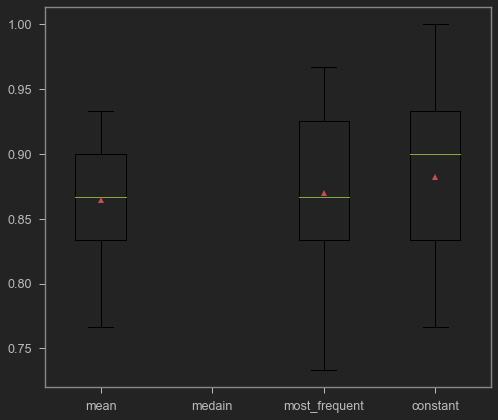

In [26]:
#evaluation strategy
results =list()
strategies = ["mean","medain","most_frequent","constant"]
for s in strategies:
    #pipeline
    pipeline = Pipeline(steps=[("i", SimpleImputer(strategy=s)),("m",RandomForestClassifier())])
    #def model eval
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
    #eval model
    scores = cross_val_score(pipeline, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
    #store results
    results.append(scores)
    print(">%s %0.3f (%0.3f)" % (s, np.mean(scores)*100, np.std(scores)))
    
#plot model performance for comaprison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()